In [37]:
import sys
sys.path.insert(1, '/home/kheyblom/aura/codes/my_functions/')
sys.path.insert(1, '/net/venus/kenes/user/kheyblom/projects/tags/')
sys.path.insert(1, '/net/venus/kenes/user/kheyblom/projects/isotopes/')
from importlib import reload
import myfunc as my; reload(my)
import MyFunc as myold; reload(myold)
import myplot as myplt; reload(myplt)
import tag_func as mytag; reload(mytag)
import iso_func as myiso; reload(myiso)
import pickle
import xarray as xr
from xarray.ufuncs import trunc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator, AutoMinorLocator, FixedLocator
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D
import matplotlib.animation as animation
%matplotlib inline
from scipy import signal, stats, interpolate, integrate
from IPython.display import clear_output, display
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from cartopy.util import add_cyclic_point
import dask
from dask import delayed, compute
import cftime as cf
from datetime import timedelta, datetime
# import warnings; warnings.simplefilter('ignore')
from numba import njit, prange, config, threading_layer
config.THREADING_LAYER = 'threadsafe'

In [38]:
# get tag names

tags = mytag.get_tags()
tagid = [x[0] for x in tags]
tag_coords = {tagid[i]: [x[1:5] for x in tags][i] for i in range(len(tagid))}
tag_coords_lat = {key:value for (key,value) in tag_coords.items() if key[:3]=='LAT'}
tag_coords_lon = {key:value for (key,value) in tag_coords.items() if key[:3]=='LON'}
tagid_lat = list(tag_coords_lat.keys())
tagid_lon = list(tag_coords_lon.keys())

In [39]:
data_dir = '/home/kheyblom/kenes/data/icesm-output/mon'

In [40]:
mbrs = {'hist-tags': ['historical-iso-r3-tags'],
        'rcp85-tags':['rcp85_r3-tags']}
mbrs_label = ['r3']

In [41]:
start_yrs = [1949,1999,2069]

In [42]:
%%time
reload(mytag)
precip_tags_lat = ['PRECRC_{}r'.format(x) for x in tagid_lat] + ['PRECRL_{}R'.format(x) for x in tagid_lat] + \
                    ['PRECSC_{}s'.format(x) for x in tagid_lat] + ['PRECSL_{}S'.format(x) for x in tagid_lat]
data_lat = mytag.open_tagvars(precip_tags_lat,mbrs,mbrs_label,remove_years=start_yrs)

opening: r3


OSError: no files to open

In [15]:
%%time
precip_tags_lon = ['PRECRC_{}r'.format(x) for x in tagid_lon] + ['PRECRL_{}R'.format(x) for x in tagid_lon] + \
                    ['PRECSC_{}s'.format(x) for x in tagid_lon] + ['PRECSL_{}S'.format(x) for x in tagid_lon]
data_lon = mytag.open_tagvars(precip_tags_lon,mbrs,mbrs_label,remove_years=start_yrs)

opening: r3
CPU times: user 16.6 s, sys: 1.7 s, total: 18.3 s
Wall time: 17.6 s


In [16]:
lats = data_lat.lat.data
lons = data_lat.lon.data
times = data_lat.time.data

In [17]:
%%time
pr_lat = []
for i,itag in enumerate(tagid_lat): 
    print(itag); clear_output(wait=True)
    pr_lat.append(data_lat['PRECRC_{}r'.format(itag)] + data_lat['PRECRL_{}R'.format(itag)] + \
                  data_lat['PRECSC_{}s'.format(itag)] + data_lat['PRECSL_{}S'.format(itag)])
print('concat')
pr_lat = xr.concat(pr_lat,'tagid')*1000*3600*24 #mm/day
pr_lat['tagid'] = tagid_lat
# print('compute')
# pr_lat = pr_lat.compute()

concat
CPU times: user 137 ms, sys: 6.21 ms, total: 144 ms
Wall time: 136 ms


In [18]:
%%time
pr_lon = []
for i,itag in enumerate(tagid_lon):
    print(itag); clear_output(wait=True)
    pr_lon.append(data_lon['PRECRC_{}r'.format(itag)] + data_lon['PRECRL_{}R'.format(itag)] + \
                  data_lon['PRECSC_{}s'.format(itag)] + data_lon['PRECSL_{}S'.format(itag)])
print('concat')
pr_lon = xr.concat(pr_lon,'tagid')*1000*3600*24 #mm/day
pr_lon['tagid'] = tagid_lon
# print('compute')
# pr_lon = pr_lon.compute()

concat
CPU times: user 275 ms, sys: 6.45 ms, total: 282 ms
Wall time: 267 ms


In [19]:
# create lat grid
lat_mids = np.sort(list({(bnd[0]+bnd[1])/2 for (key,bnd) in tag_coords_lat.items()}))
lat_mids

array([-85., -75., -65., -55., -45., -35., -25., -15.,  -5.,   5.,  15.,
        25.,  35.,  45.,  55.,  65.,  75.,  85.])

In [20]:
# create lon grid
lon_mids = np.sort(list({(bnd[2]+bnd[3])/2 for (key,bnd) in tag_coords_lon.items()}))
lon_mids

array([  5.,  15.,  25.,  35.,  45.,  55.,  65.,  75.,  85.,  95., 105.,
       115., 125., 135., 145., 155., 165., 175., 185., 195., 205., 215.,
       225., 235., 245., 255., 265., 275., 285., 295., 305., 315., 325.,
       335., 345., 355.])

In [21]:
test_lat = pr_lat[:,0,150,100]
test_lat

<xarray.DataArray (tagid: 18)>
dask.array<getitem, shape=(18,), dtype=float32, chunksize=(1,), chunktype=numpy.ndarray>
Coordinates:
    time     object 1950-01-01 00:00:00
    lat      float64 51.36
    lon      float64 125.0
  * tagid    (tagid) <U6 'LAT85S' 'LAT75S' 'LAT65S' ... 'LAT75N' 'LAT85N'

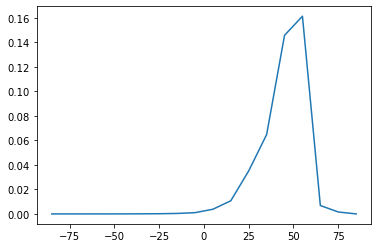

In [95]:
plt.plot(lat_mids,test_lat)

In [96]:
test_lon = pr_lon[:,0,150,100]
test_lon

<xarray.DataArray (tagid: 36)>
array([0.00513121, 0.00656349, 0.00536994, 0.00581431, 0.01014845,
       0.01037092, 0.00245333, 0.00149101, 0.00226885, 0.00337381,
       0.00589012, 0.00739773, 0.04387659, 0.01981702, 0.03229625,
       0.03479968, 0.03367201, 0.03029341, 0.02994852, 0.02866552,
       0.0180151 , 0.01602528, 0.00510063, 0.00186557, 0.0005975 ,
       0.00117071, 0.00142821, 0.00238908, 0.00624049, 0.00935155,
       0.01066092, 0.01003101, 0.00862818, 0.01023761, 0.00825818,
       0.00438587], dtype=float32)
Coordinates:
    time     object 1950-01-01 00:00:00
    lat      float64 51.36
    lon      float64 125.0
  * tagid    (tagid) <U7 'LON05E' 'LON15E' 'LON25E' ... 'LON345E' 'LON355E'

In [97]:
test_lon_norm = test_lon/np.sum(test_lon)

In [98]:
test_lon_norm

<xarray.DataArray (tagid: 36)>
array([0.01182229, 0.01512228, 0.01237233, 0.01339617, 0.02338202,
       0.02389458, 0.00565248, 0.00343529, 0.00522743, 0.00777326,
       0.01357082, 0.01704435, 0.10109159, 0.04565839, 0.0744105 ,
       0.08017842, 0.07758026, 0.06979597, 0.06900133, 0.06604531,
       0.04150675, 0.03692222, 0.01175184, 0.00429828, 0.00137664,
       0.00269732, 0.0032906 , 0.00550444, 0.01437807, 0.02154595,
       0.02456274, 0.02311143, 0.01987931, 0.02358744, 0.01902684,
       0.01010504], dtype=float32)
Coordinates:
    time     object 1950-01-01 00:00:00
    lat      float64 51.36
    lon      float64 125.0
  * tagid    (tagid) <U7 'LON05E' 'LON15E' 'LON25E' ... 'LON345E' 'LON355E'

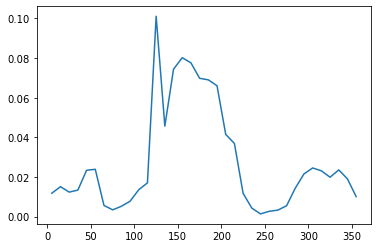

In [99]:
plt.plot(lon_mids,test_lon_norm)

In [106]:
np.sum(test_lat)

<xarray.DataArray ()>
array(0.431834, dtype=float32)
Coordinates:
    time     object 1950-01-01 00:00:00
    lat      float64 51.36
    lon      float64 125.0

In [107]:
np.sum(test_lon)

<xarray.DataArray ()>
array(0.4340281, dtype=float32)
Coordinates:
    time     object 1950-01-01 00:00:00
    lat      float64 51.36
    lon      float64 125.0

In [108]:
np.sum(pr_tags)

0.431834

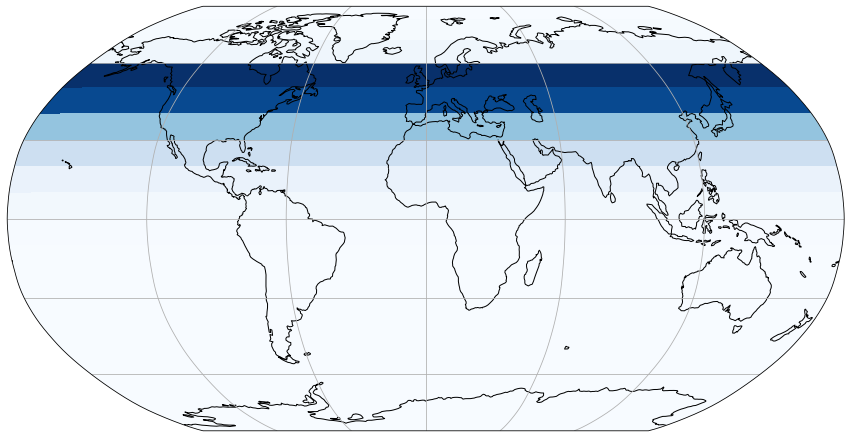

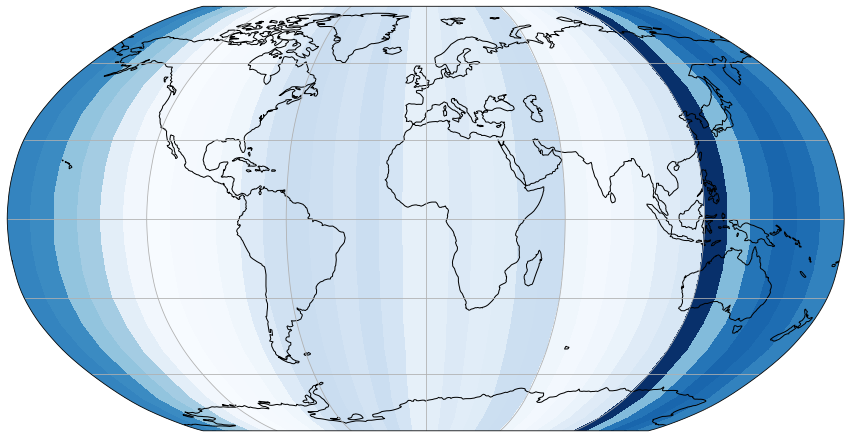

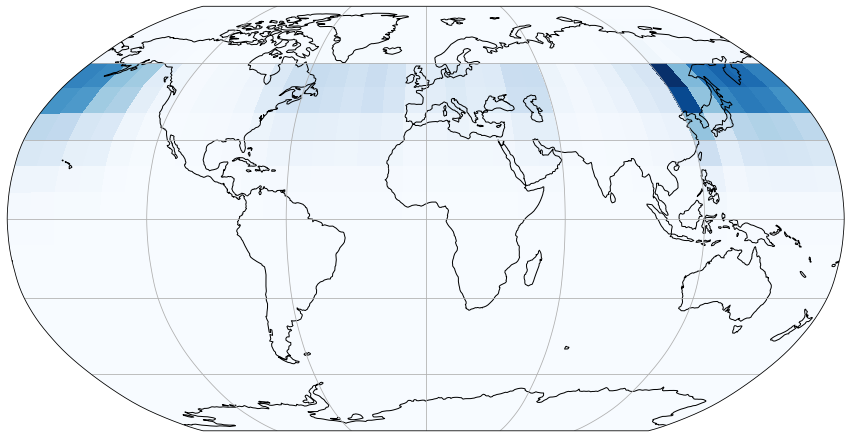

In [105]:
pr_lon3, pr_lat3 = np.meshgrid(test_lon_norm,test_lat)
pr_tags = pr_lon3*pr_lat3


fig = plt.figure(figsize=(15,10))
cl = 20
ax = plt.axes(projection=ccrs.Robinson())
ax.coastlines()
ax.gridlines()
ax.set_global()
q = ax.pcolormesh(lon_mids, lat_mids, pr_lat3, transform=ccrs.PlateCarree(), cmap='Blues')

fig = plt.figure(figsize=(15,10))
cl = 20
ax = plt.axes(projection=ccrs.Robinson())
ax.coastlines()
ax.gridlines()
ax.set_global()
q = ax.pcolormesh(lon_mids, lat_mids, pr_lon3, transform=ccrs.PlateCarree(), cmap='Blues')


fig = plt.figure(figsize=(15,10))
ax = plt.axes(projection=ccrs.Robinson())
ax.coastlines()
ax.gridlines()
ax.set_global()
q = ax.pcolormesh(lon_mids, lat_mids, pr_tags, transform=ccrs.PlateCarree(), cmap='Blues')
# plt.colorbar(q)

In [44]:
def pr_src(prtag_lat,prtag_lon):
    '''
    Approximate source location from lat and lon tags
    
    --> convolves lat and lon source regions by multiplying lat source precip distrbution by normalized lon ditribution
    
    input:
    --------
    prtag_lat, prtag_lon: vectors of source precip from each lat,lon band
    
    returns:
    --------
    approximated precip from a source region grid of lon x lat
    '''
    prtag_lon_norm = prtag_lon/np.sum(prtag_lon)
    pr_lon3, pr_lat3 = np.meshgrid(prtag_lon_norm,prtag_lat)
    return pr_lon3*pr_lat3

In [67]:
%%time
X = np.array([20,34,45,61]).reshape(-1,1)
Y = np.array([52,35,49]).reshape(-1,1)
PX = X/np.sum(X)
PY = Y/np.sum(Y)

PX@PY.T

CPU times: user 271 µs, sys: 0 ns, total: 271 µs
Wall time: 284 µs


array([[0.04779412, 0.03216912, 0.04503676],
       [0.08125   , 0.0546875 , 0.0765625 ],
       [0.10753676, 0.07238051, 0.10133272],
       [0.14577206, 0.09811581, 0.13736213]])

In [68]:
%%time
X = np.array([20,34,45,61])
Y = np.array([52,35,49])
PX = X/np.sum(X)
PY = Y/np.sum(Y)

np.outer(PX,PY)

CPU times: user 477 µs, sys: 0 ns, total: 477 µs
Wall time: 365 µs


array([[0.04779412, 0.03216912, 0.04503676],
       [0.08125   , 0.0546875 , 0.0765625 ],
       [0.10753676, 0.07238051, 0.10133272],
       [0.14577206, 0.09811581, 0.13736213]])

In [66]:
%%time
PX@PY.T

CPU times: user 43 µs, sys: 38 µs, total: 81 µs
Wall time: 92 µs


array([[0.04779412, 0.03216912, 0.04503676],
       [0.08125   , 0.0546875 , 0.0765625 ],
       [0.10753676, 0.07238051, 0.10133272],
       [0.14577206, 0.09811581, 0.13736213]])

In [ ]:
%%time
PX@PY.T

In [65]:
np.sum(PX@PY.T)

0.9999999999999999

In [45]:
pr_src(Y,X)

array([[ 6.5    , 11.05   , 14.625  , 19.825  ],
       [ 4.375  ,  7.4375 ,  9.84375, 13.34375],
       [ 6.125  , 10.4125 , 13.78125, 18.68125]])

In [49]:
Y[1]*PX

array([ 4.375  ,  7.4375 ,  9.84375, 13.34375])

In [50]:
np.sum(Y[1]*PX)

35.0

In [51]:
PY

array([0.38235294, 0.25735294, 0.36029412])

In [54]:
pr_src(PY,PX)

array([[0.04779412, 0.08125   , 0.10753676, 0.14577206],
       [0.03216912, 0.0546875 , 0.07238051, 0.09811581],
       [0.04503676, 0.0765625 , 0.10133272, 0.13736213]])

In [30]:
PX*PY[1]

array([0.03216912, 0.0546875 , 0.07238051, 0.09811581])

In [34]:
np.sum(PX/PY[0])

2.6153846153846154

In [35]:
np.sum(PX/PY[1])

3.885714285714286

In [36]:
np.sum(PX/PY[2])

2.7755102040816326

In [ ]:
test_lat

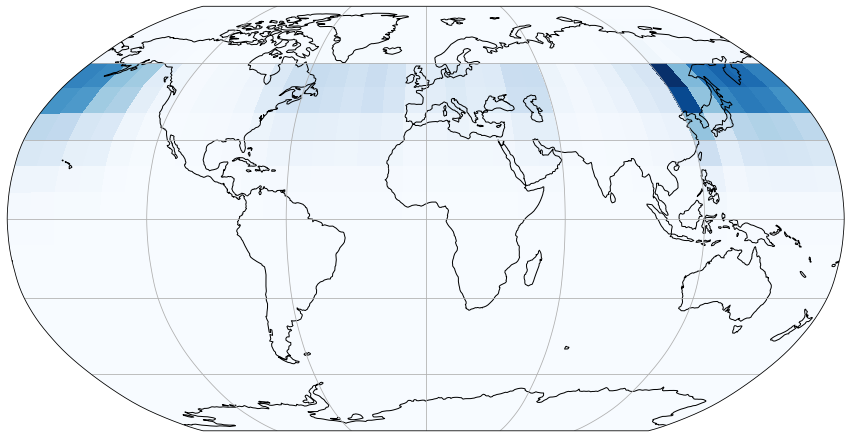

In [112]:
pr_tags = pr_src(test_lat,test_lon)


fig = plt.figure(figsize=(15,10))
ax = plt.axes(projection=ccrs.Robinson())
ax.coastlines()
ax.gridlines()
ax.set_global()
q = ax.pcolormesh(lon_mids, lat_mids, pr_tags, transform=ccrs.PlateCarree(), cmap='Blues')

In [24]:
%%time
pr_tags = pr_src(test_lat,test_lon)

NameError: name 'test_lon' is not defined

In [117]:
test_lat

<xarray.DataArray (tagid: 18)>
array([3.0167350e-05, 3.0224182e-05, 3.0787720e-05, 3.4431236e-05,
       5.3034473e-05, 1.1180798e-04, 1.8970686e-04, 4.1041774e-04,
       1.0599620e-03, 3.8457646e-03, 1.0778718e-02, 3.5151400e-02,
       6.4740539e-02, 1.4565863e-01, 1.6119796e-01, 6.8715243e-03,
       1.6031114e-03, 3.5857051e-05], dtype=float32)
Coordinates:
    time     object 1950-01-01 00:00:00
    lat      float64 51.36
    lon      float64 125.0
  * tagid    (tagid) <U6 'LAT85S' 'LAT75S' 'LAT65S' ... 'LAT75N' 'LAT85N'

In [114]:
pr_tags.shape

(18, 36)

In [25]:
test_lat = pr_lat[:,0,150,100]
test_lon = pr_lon[:,0,150,100]

In [26]:
latS = -10
latN = 0
lonE = 300
lonW = 310

test_lat = my.globalmean(pr_lat.sel(time=slice('1950','1979'),lat=slice(latS,latN),lon=slice(lonE,lonW)).mean('time'))
test_lon = my.globalmean(pr_lon.sel(time=slice('1950','1979'),lat=slice(latS,latN),lon=slice(lonE,lonW)).mean('time'))

In [27]:
%%time
print('compute')
test_lat = test_lat.compute()

compute
CPU times: user 5.72 s, sys: 13 s, total: 18.7 s
Wall time: 4min 38s


In [28]:
%%time
print('compute')
test_lon = test_lon.compute()

compute
CPU times: user 11.3 s, sys: 25.1 s, total: 36.5 s
Wall time: 7min 45s


In [29]:
%%time
pr_tags = pr_src(test_lat,test_lon)

CPU times: user 1.51 ms, sys: 0 ns, total: 1.51 ms
Wall time: 1.41 ms


/tmp/ipykernel_1380914/1382196016.py:13: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
  ax.outline_patch.set_linewidth(3.5)


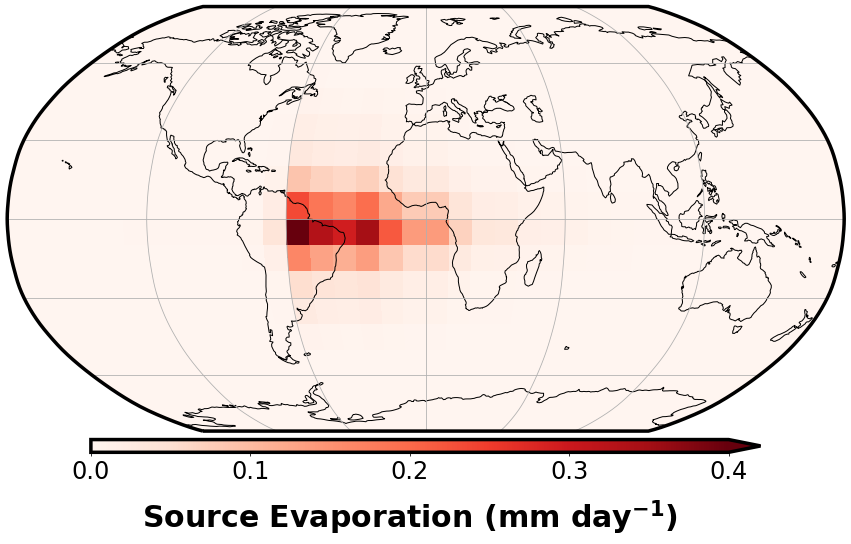

In [30]:
vmin,vmax=0,0.4
nticks=5
extend='max'
fs1 = 30
fs2 = 24
cblabel=r'Source Evaporation (mm day$^{\mathbf{-1}}$)'

fig = plt.figure(figsize=(15,10))
ax = plt.axes(projection=ccrs.Robinson())
ax.coastlines()
ax.gridlines()
ax.set_global()
ax.outline_patch.set_linewidth(3.5)
q = ax.pcolormesh(lon_mids, lat_mids, pr_tags, transform=ccrs.PlateCarree(), cmap='Reds',vmin=vmin,vmax=vmax)
cbar_ax = ax.inset_axes([0.1, -0.05, 0.8, 0.03])
cbar = fig.colorbar(q,cax=cbar_ax,orientation='horizontal',ticks=np.linspace(vmin,vmax,nticks), extend=extend)
cbar.ax.tick_params(labelsize=fs2)
cbar.set_label(cblabel,fontsize=fs1,fontweight='bold',labelpad=15)
cbar.outline.set_linewidth(3.5)

In [31]:
lats_grids = np.arange(-90,90,10)
lons_grids = np.arange(-180,180,10)

/tmp/ipykernel_1380914/1236250420.py:15: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
  ax.outline_patch.set_linewidth(3.5)


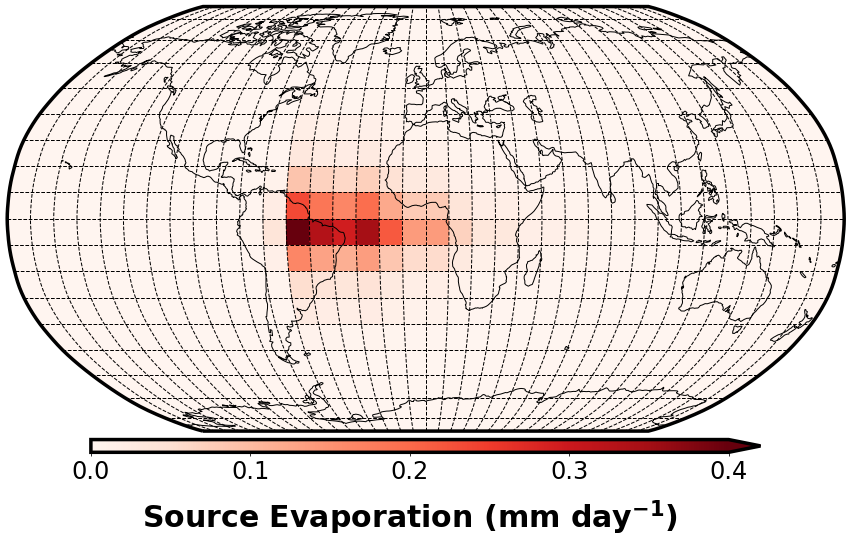

In [32]:
vmin,vmax=0,0.4
nticks=5
extend='max'
fs1 = 30
fs2 = 24
cblabel=r'Source Evaporation (mm day$^{\mathbf{-1}}$)'

fig = plt.figure(figsize=(15,10))
ax = plt.axes(projection=ccrs.Robinson())
ax.coastlines()
gl = ax.gridlines(draw_labels=False,linewidth=1, color='k', alpha=1, linestyle='--')
gl.ylocator = FixedLocator(lats_grids)
gl.xlocator = FixedLocator(lons_grids)
ax.set_global()
ax.outline_patch.set_linewidth(3.5)
q = ax.pcolormesh(lon_mids, lat_mids, pr_tags, transform=ccrs.PlateCarree(), cmap='Reds',vmin=vmin,vmax=vmax)
cbar_ax = ax.inset_axes([0.1, -0.05, 0.8, 0.03])
cbar = fig.colorbar(q,cax=cbar_ax,orientation='horizontal',ticks=np.linspace(vmin,vmax,nticks), extend=extend)
cbar.ax.tick_params(labelsize=fs2)
cbar.set_label(cblabel,fontsize=fs1,fontweight='bold',labelpad=15)
cbar.outline.set_linewidth(3.5)

/tmp/ipykernel_1380914/4198048326.py:15: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
  ax.outline_patch.set_linewidth(3.5)


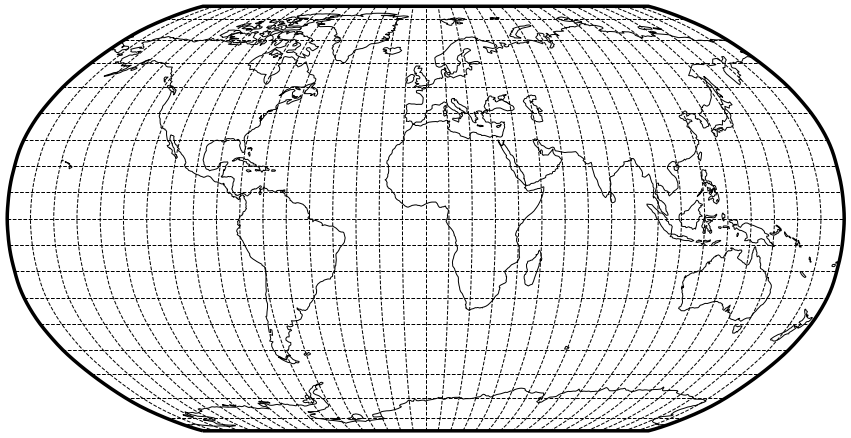

In [34]:
vmin,vmax=0,0.4
nticks=5
extend='max'
fs1 = 30
fs2 = 24
cblabel=r'Source Evaporation (mm day$^{\mathbf{-1}}$)'

fig = plt.figure(figsize=(15,10))
ax = plt.axes(projection=ccrs.Robinson())
ax.coastlines()
gl = ax.gridlines(draw_labels=False,linewidth=1, color='k', alpha=1, linestyle='--')
gl.ylocator = FixedLocator(lats_grids)
gl.xlocator = FixedLocator(lons_grids)
ax.set_global()
ax.outline_patch.set_linewidth(3.5)
# q = ax.pcolormesh(lon_mids, lat_mids, pr_tags, transform=ccrs.PlateCarree(), cmap='Reds',vmin=vmin,vmax=vmax)
# cbar_ax = ax.inset_axes([0.1, -0.05, 0.8, 0.03])
# cbar = fig.colorbar(q,cax=cbar_ax,orientation='horizontal',ticks=np.linspace(vmin,vmax,nticks), extend=extend)
# cbar.ax.tick_params(labelsize=fs2)
# cbar.set_label(cblabel,fontsize=fs1,fontweight='bold',labelpad=15)
# cbar.outline.set_linewidth(3.5)

In [45]:
test_lat.max()

<xarray.DataArray ()>
array(2.14530403)

/tmp/ipykernel_1380914/4124793161.py:17: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
  ax.outline_patch.set_linewidth(3.5)


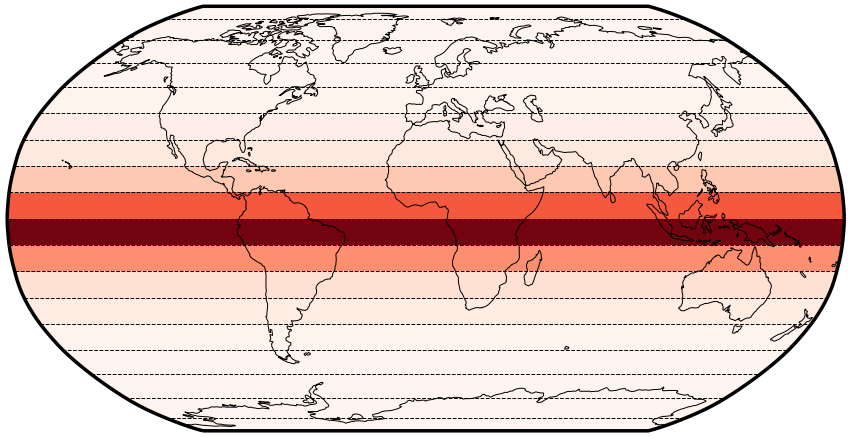

In [59]:
test_lon3d,test_lat3d = np.meshgrid(test_lon,test_lat)

vmin,vmax=0,2.2
nticks=5
extend='max'
fs1 = 30
fs2 = 24
cblabel=r'Source Evaporation (mm day$^{\mathbf{-1}}$)'

fig = plt.figure(figsize=(15,10))
ax = plt.axes(projection=ccrs.Robinson())
ax.coastlines()
gl = ax.gridlines(draw_labels=False,linewidth=1, color='k', alpha=1, linestyle='--')
gl.ylocator = FixedLocator(lats_grids)
gl.xlocator = FixedLocator([])
ax.set_global()
ax.outline_patch.set_linewidth(3.5)
q = ax.pcolormesh(lon_mids, lat_mids, test_lat3d, transform=ccrs.PlateCarree(), cmap='Reds',vmin=vmin,vmax=vmax)
# cbar_ax = ax.inset_axes([0.1, -0.05, 0.8, 0.03])
# cbar = fig.colorbar(q,cax=cbar_ax,orientation='horizontal',ticks=np.linspace(vmin,vmax,nticks), extend=extend)
# cbar.ax.tick_params(labelsize=fs2)
# cbar.set_label(cblabel,fontsize=fs1,fontweight='bold',labelpad=15)
# cbar.outline.set_linewidth(3.5)

/tmp/ipykernel_1380914/1447075556.py:17: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
  ax.outline_patch.set_linewidth(3.5)


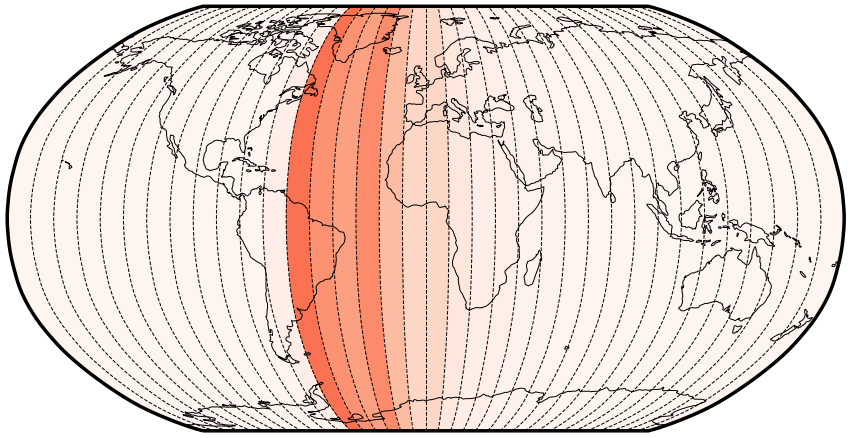

In [58]:
test_lon3d,test_lat3d = np.meshgrid(test_lon,test_lat)

vmin,vmax=0,2.2
nticks=5
extend='max'
fs1 = 30
fs2 = 24
cblabel=r'Source Evaporation (mm day$^{\mathbf{-1}}$)'

fig = plt.figure(figsize=(15,10))
ax = plt.axes(projection=ccrs.Robinson())
ax.coastlines()
gl = ax.gridlines(draw_labels=False,linewidth=1, color='k', alpha=1, linestyle='--')
gl.ylocator = FixedLocator([])
gl.xlocator = FixedLocator(lons_grids)
ax.set_global()
ax.outline_patch.set_linewidth(3.5)
q = ax.pcolormesh(lon_mids, lat_mids, test_lon3d, transform=ccrs.PlateCarree(), cmap='Reds',vmin=vmin,vmax=vmax)
# cbar_ax = ax.inset_axes([0.1, -0.05, 0.8, 0.03])
# cbar = fig.colorbar(q,cax=cbar_ax,orientation='horizontal',ticks=np.linspace(vmin,vmax,nticks), extend=extend)
# cbar.ax.tick_params(labelsize=fs2)
# cbar.set_label(cblabel,fontsize=fs1,fontweight='bold',labelpad=15)
# cbar.outline.set_linewidth(3.5)

/tmp/ipykernel_1380914/2800155601.py:8: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
  ax.outline_patch.set_linewidth(3.5)


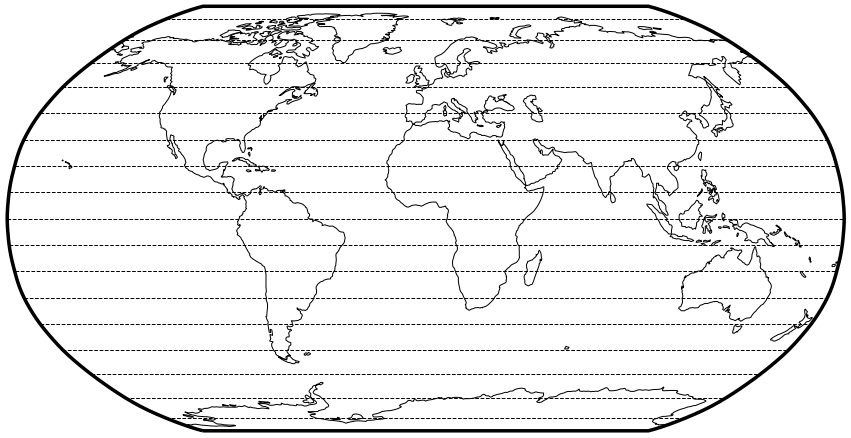

In [53]:
fig = plt.figure(figsize=(15,10))
ax = plt.axes(projection=ccrs.Robinson())
ax.coastlines()
gl = ax.gridlines(draw_labels=False,linewidth=1, color='k', alpha=1, linestyle='--')
gl.ylocator = FixedLocator(lats_grids)
gl.xlocator = FixedLocator([])
ax.set_global()
ax.outline_patch.set_linewidth(3.5)

/tmp/ipykernel_1380914/3173347490.py:8: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
  ax.outline_patch.set_linewidth(3.5)


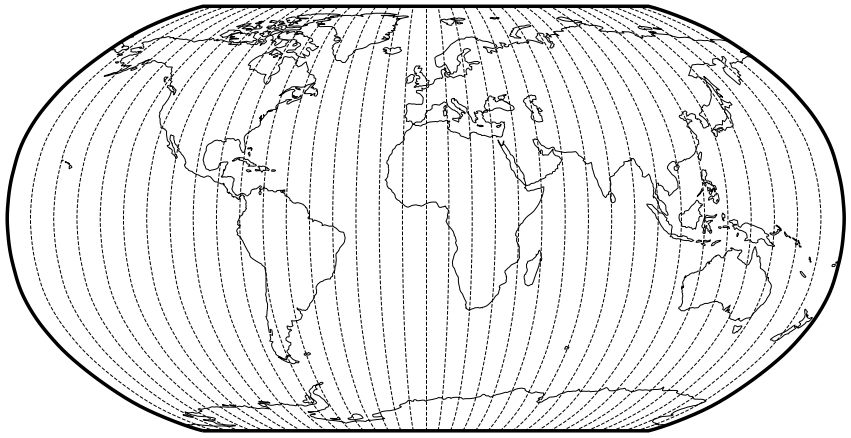

In [54]:
fig = plt.figure(figsize=(15,10))
ax = plt.axes(projection=ccrs.Robinson())
ax.coastlines()
gl = ax.gridlines(draw_labels=False,linewidth=1, color='k', alpha=1, linestyle='--')
gl.ylocator = FixedLocator([])
gl.xlocator = FixedLocator(lons_grids)
ax.set_global()
ax.outline_patch.set_linewidth(3.5)

/tmp/ipykernel_1380914/682507058.py:8: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
  ax.outline_patch.set_linewidth(3.5)


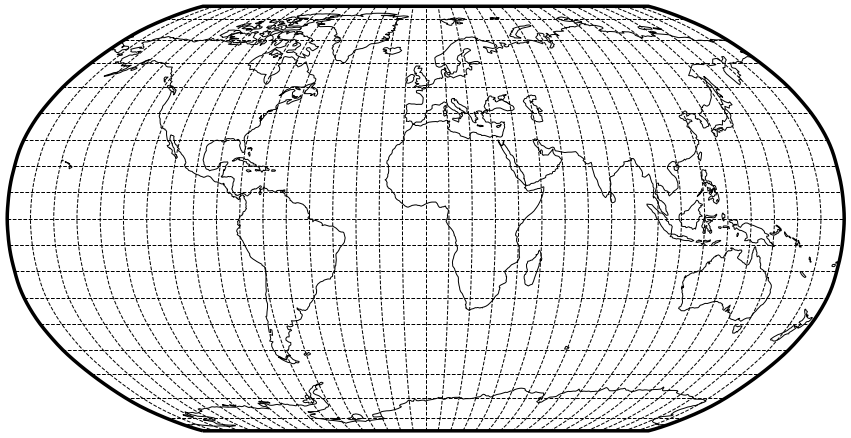

In [55]:
fig = plt.figure(figsize=(15,10))
ax = plt.axes(projection=ccrs.Robinson())
ax.coastlines()
gl = ax.gridlines(draw_labels=False,linewidth=1, color='k', alpha=1, linestyle='--')
gl.ylocator = FixedLocator(lats_grids)
gl.xlocator = FixedLocator(lons_grids)
ax.set_global()
ax.outline_patch.set_linewidth(3.5)

In [36]:
pr_tags.max()

0.418173718714163

In [37]:
pr_tags_old.max()

1.498862613343255

In [29]:
def pr_src_old(prtag_lat,prtag_lon):
    '''
    Approximate source location from lat and lon tags
    
    --> convolves lat and lon source regions by multiplying lat source precip distrbution by normalized lon ditribution
    
    input:
    --------
    prtag_lat, prtag_lon: vectors of source precip from each lat,lon band
    
    returns:
    --------
    approximated precip from a source region grid of lon x lat
    '''
    pr_lon3, pr_lat3 = np.meshgrid(prtag_lon,prtag_lat)
    return np.sqrt(pr_lon3*pr_lat3)

In [30]:
%%time
pr_tags_old = pr_src_old(test_lat,test_lon)

CPU times: user 515 µs, sys: 390 µs, total: 905 µs
Wall time: 934 µs


/tmp/ipykernel_2268266/158167248.py:13: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
  ax.outline_patch.set_linewidth(3.5)


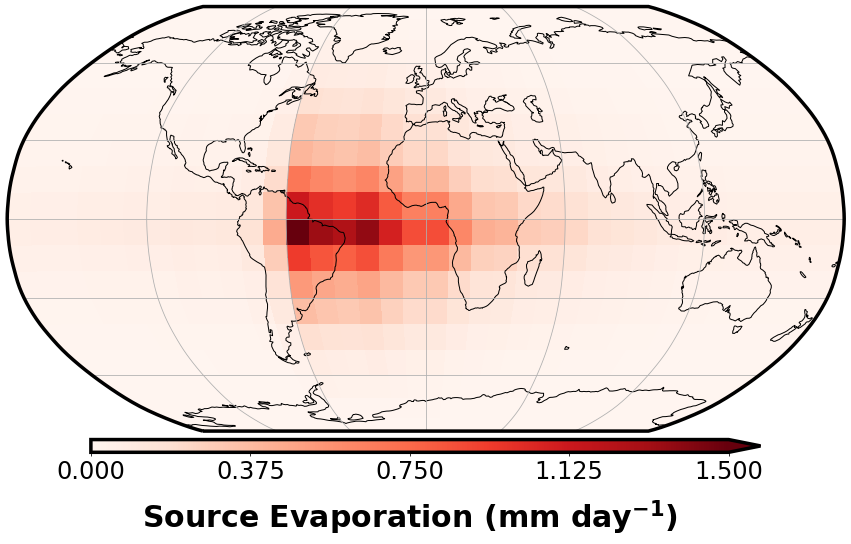

In [38]:
vmin,vmax=0,1.5
nticks=5
extend='max'
fs1 = 30
fs2 = 24
cblabel=r'Source Evaporation (mm day$^{\mathbf{-1}}$)'

fig = plt.figure(figsize=(15,10))
ax = plt.axes(projection=ccrs.Robinson())
ax.coastlines()
ax.gridlines()
ax.set_global()
ax.outline_patch.set_linewidth(3.5)
q = ax.pcolormesh(lon_mids, lat_mids, pr_tags_old, transform=ccrs.PlateCarree(), cmap='Reds',vmin=vmin,vmax=vmax)
cbar_ax = ax.inset_axes([0.1, -0.05, 0.8, 0.03])
cbar = fig.colorbar(q,cax=cbar_ax,orientation='horizontal',ticks=np.linspace(vmin,vmax,nticks), extend=extend)
cbar.ax.tick_params(labelsize=fs2)
cbar.set_label(cblabel,fontsize=fs1,fontweight='bold',labelpad=15)
cbar.outline.set_linewidth(3.5)

In [115]:
F = np.array([[0,2,4],
              [1,0,9],
              [3,6,0]])
T = np.array([[1,0,0],
              [0,5,0],
              [0,0,6]])

In [116]:
F@T

array([[ 0, 10, 24],
       [ 1,  0, 54],
       [ 3, 30,  0]])

In [126]:
A = np.array([1,2,4])
T = np.array([[1,4,5],
              [4,5,0],
              [2,9,6]])

In [127]:
T@A

array([29, 14, 44])

In [124]:
np.array([1,2,4])@np.eye(3)

array([1., 2., 4.])

In [125]:
np.eye(3)@np.array([1,2,4])

array([1., 2., 4.])

In [128]:
np.shape(A)

(3,)

In [130]:
np.eye(3)@A

array([1., 2., 4.])